# Q learning : application

Dans cette séance on testera l'algorithme de Q learning avec un environnement de simulation d'OpenAI gym

https://www.gymlibrary.dev/


### Quelques installations

Selon ce qui est déjà installé dans votre environnement de travail, vous aurez besoin de quelques librairies. 

In [1]:
!pip install ipywidgets numpy ffmpeg ffmpeg-python tqdm
!pip install gym[Box2D]==0.25.1
# si toujours des problèmes avec ffmpeg: 
#!conda install ffmpeg

In [1]:
import gym
import matplotlib
import matplotlib.pyplot as plt

import numpy as np
import matplotlib.animation as animation
import matplotlib.cm as cm

In [2]:
# pour lire des videos locales facilement
from base64 import b64encode
from IPython.display import HTML


def play_video(v_path,width=400):
      mp4 = open(v_path,'rb').read()
      data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
      return HTML("""
          <video width=%d controls>
          <source src="%s" type="video/mp4">
          </video>
          """ % (width,data_url))

# images sauvées pendant la simulation -> video 
def make_video(images,outfile="movie.mp4"):
    fig = plt.figure()
    img_frames = [[plt.imshow(img,cmap=cm.Greys_r,animated=True)] for img in images]
    ani = animation.ArtistAnimation(fig, img_frames, interval=50, blit=True,
                                repeat_delay=1000)
    ani.save(outfile)

## Découverte des environnements d'OpenAI Gym

Gym définit des mondes dans lesquels on peut avoir un agent qui agit sur l'environnement, et avoir l'observation de certaines variables de cet environnement.

<img src="https://upload.wikimedia.org/wikipedia/commons/c/cd/Reinforcement_learning_diagram_fr.svg" width=400>

On utilisera plusieurs environnements, mais voyons déjà celui ci:
un module lunaire essaie d'atterrir en douceur sur un emplacement fixé

<img src="https://www.gymlibrary.dev/_images/lunar_lander_continuous.gif" width=400>

In [3]:
# On charge un environnement. l'option render_mode détermine le rendu visuel des simulations. 
# ici on sauvera des images
env = gym.make("LunarLander-v2",render_mode="rgb_array",new_step_api="True")

# on l'initialise sur un état de départ. -> renvoie une "observation" : un état de l'environnement
env.reset()

array([ 0.00162678,  1.4010214 ,  0.16475639, -0.43994334, -0.00187822,
       -0.03731988,  0.        ,  0.        ], dtype=float32)

Chaque environnement comprend un espace d'actions possibles par l'agent, qui est ici un module d'atterrissage lunaire doté de deux moteurs latéraux, et un moteur principal. L'agent peut aussi ne rien faire. 

In [4]:
# Espace des actions 
# Nop, fire left engine, main engine, right engine
print(env.action_space)
# on peut échantilloner une action au hasard
print(env.action_space.sample())

Discrete(4)
2


In [5]:
print(env.action_space.n)

4


L'environnement définit un certain nombre de variables observables.

In [6]:
# Espace des observations
# 0,1: Position X, Y
# 2,3: vitesse vx, vx
# 4: angle / vertical 
# 5: angle vitesse rotation 
# 6,7: pas utilisés

obs = env.reset()
print(obs.shape)
obs

(8,)


array([ 4.3745042e-04,  1.4132037e+00,  4.4291962e-02,  1.0149287e-01,
       -5.0010416e-04, -1.0032790e-02,  0.0000000e+00,  0.0000000e+00],
      dtype=float32)

A chaque action faite par un agent, l'environnement informe sur le nouvel état, donne une récompense (prédéfinie et fixé pour chaque monde), et renvoie aussi une condition qui précise si la simulation est finie (crash ou atterrissage réussi). 

In [7]:
#faire une action, constater l'état suivant, reward etc
observation, reward, done, truncated, info = env.step(1)
print(reward, done, truncated, info, end="\n")

2.574857919884154 False False {}


## I) Ecrire une fonction de simulation qui fait une séquence d'action au hasard

et enregistre les récompenses et la trajectoire de chaque variable observée. 


In [10]:
# version à compléter
def random_sequence(env,nb):
        observation = env.reset()
        # sauve les observations pour faire des stats
        trajectory = ...
        # somme des renforcements
        total = 0 
        for t in range(nb):
            # compléter ici ...
            ...
            if done:
               ... 
        env.close()
        return final, total, trajectory

Episode finished after 68 timesteps
final reward =  -100
total reward =  -153.34124960952659


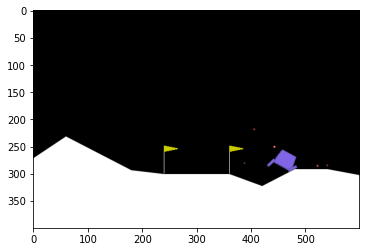

In [11]:
env = gym.make("LunarLander-v2",render_mode="rgb_array",new_step_api=True)
final, total, trajectory = random_sequence(env,200)
print("final reward = ",final)
print("total reward = ", total)
# render sauve la simulation depuis le dernier env.reset()
images = env.render()
make_video(images,"movie.mp4")
# devrait donner une récompense finale de -100
# et un total variable entre -100 et -xxx

In [12]:
play_video("movie.mp4",width=600)

In [13]:
# si probleme pendant affichage externe, exécuter l'instruction:
env.close()

In [14]:
trajectory = np.array(trajectory)

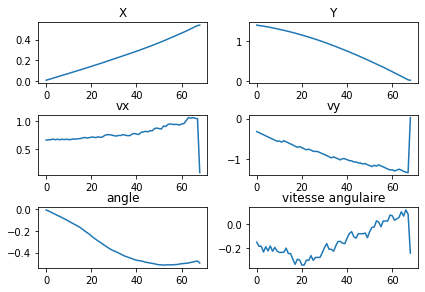

In [15]:
# On peut observer l'évolution des variables au cours de la simulation

# Espace des observations
variables = {0:"X",1:"Y",   # Position X, Y
             2:"vx",3:"vy", # vecteur vitesse vx, vx
             4:"angle",     # / vertical 
             5:"vitesse angulaire", 
            }
%matplotlib inline
fig, axs = plt.subplots(3,2)
fig.tight_layout()
fig.figsize = (20,20) 
for i in range(6):
    axs[i//2,i%2].set_title(variables[i])
    axs[i//2,i%2].plot(trajectory[:,i])
    

## Q learning dans l'environnement Frozen Lake

Nous allons expérimenter le Q-learning dans un environnement un peu plus simple avec peu d'états: le "frozen lake" où nous allons apprendre à un agent à rejoindre son but en évitant de tomber dans l'eau : 

<div>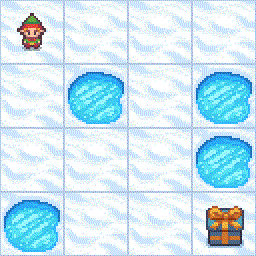</div>

N'hésitez pas à aller voir la doc: 

https://www.gymlibrary.ml/environments/toy_text/frozen_lake/

Dans une 2e partie nous  verrons aussi que l'environnement peut être traitre avec des actions non-déterministes (sur la glace on ne contrôle pas toujours ses mouvements !)

In [16]:
# il y a deux grilles prédéfinies de tailles 4x4 ou 8x8. 
env = gym.make("FrozenLake-v1", map_name="4x4", is_slippery=False,render_mode="rgb_array",new_step_api=True)
env.reset()

0

on peut customiser aussi en utilisant les codes : 

S=start, G=goal, H=hole, F=frozen

In [23]:
desc=["SFFF", 
      "HFFH", # variante plus dure : mettre HHFH
      "FFFF", 
      "GFFF"]
env = gym.make('FrozenLake-v1', desc=desc, is_slippery=True,render_mode="rgb_array",new_step_api=True)
env.reset()
# si aucune description ou map_name n'est donné un environnement est généré au hasard
# en forçant l'existence d'un chemin

0

on peut observer un environnement en l'affichant. ici render renvoie un vecteur d'image depuis le dernier reset()

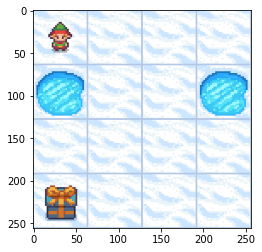

In [24]:
image = env.render()
plt.imshow(image[0])

### Explorer l'environnement

 - vérifiez le nombre d'actions, essayer de trouver quel code correspond à quelle action en observant le résultat d'une action sur un environnement donné
 - regarder ce qui définit un état donné
 - essayer de trouver les récompenses des actions selon le type de case d'arrivée en regardant la table définie par l'environement env.P

In [29]:
action_name = {0:,
               1:,
               2:,
               3:
              }

###  Q-learning

Vous allez maintenant implémenter un apprentissage par Q-learning : 

   - en définissant une table Q avec numpy (plus facile pour la suite): quelles sont les options pour initialiser cette table ? 
   - en implémentant un apprentissage $\epsilon$-greedy
   - tester avec un entrainement assez rapide pour voir que cela semble fonctionner
   - tester l'apprentissage avec la grille 4x4 "facile" puis la version "dure". 
   - afficher la courbe d'évolution de la récompense totale d'un épisode, et la politique optimale définie par votre table finale (= affichez la meilleure action pour chaque état)
   - changez les valeurs des rewards pour accélérer l'entrainement

Voici un schéma de boucle d'entrainement, qui doit dépendre d'un certain nombre de paramètres. 

In [31]:
from tqdm import tqdm



def init_Qtable(nb_states,nb_actions):
       pass

def train(n_episodes, env, max_steps, Qtable, gamma=, epsilon=, alpha=):
    ...
    for episode in tqdm(range(n_episodes)):
            # Reset the environment pour avoir l'état de départ s 
            state = env.reset()
            ...
            for step in range(max_steps):
                # choisir une action a avec la stratégie epsilon greedy
                ...     
                # faire l'action et récupérer le résultat 
                ... 
                # mise à jour de Q(s,a) 
                if not(done): # mise à jour différente si on arrive dans l'état final
                    ...
                else:
                    ...
    return Qtable, all_rewards

In [41]:
# Faites d'abord des essais sans cette partie, puis revenez ensuite compléter: 
# en fait on voit qu'avec les rewards de départ l'apprentissage est très lent
# -> on change les rewards pour guider plus

# dans cet environnement, la table des rewards est stocké dans un dictionnaire env.P 
# observez cette table avec la fonction suivante : 

def display_table(P):
    for s in P:
        print(s,P[s])
        
# on voit quel état est terminal et avec quelle récompense
# -> changer la reward pour les trous 
# -> changer aussi reward de faire un pas 


def change_rewards(P):
    ...
    return P

new = change_rewards(env.P)
env.P = new
#display_table(env.P)

In [33]:
frozen_Q = init_Qtable(nb_states,nb_actions)
frozen_Q

array([[0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.]])

In [34]:
frozen_Q, rewards  = train(???)

100%|██████████| 200/200 [00:03<00:00, 54.27it/s]


In [35]:
frozen_Q

array([[-0.15747143, -0.12108239, -0.21685639,  0.25664485],
       [ 0.07906194,  0.10412993,  0.29521234,  0.15243274],
       [ 0.25079985,  0.22779753,  0.11691763,  0.09898009],
       [-0.4       , -0.404752  , -0.4       ,  0.17526251],
       [ 0.        ,  0.        ,  0.        ,  0.        ],
       [-0.34441546, -0.4024    ,  0.46410814,  0.12702992],
       [ 0.33873591, -0.12591183, -0.05920737,  0.14637084],
       [ 0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.31282169,  0.95850638,  0.25356113,  0.35075616],
       [ 0.71087844,  0.2128385 ,  0.42060865, -0.004     ],
       [ 0.50571734, -0.004     ,  0.17926465, -0.00999476],
       [-0.4       , -0.00792   , -0.4       , -0.4024    ],
       [ 0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.73203686,  0.        ,  0.23352019,  0.4       ],
       [ 0.5249774 , -0.004     , -0.004     ,  0.17257455],
       [-0.00792   , -0.00792   , -0.00792   ,  0.26679754]])

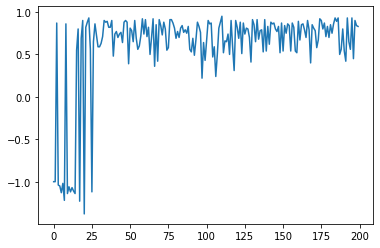

In [36]:
plt.plot(rewards)

In [37]:
print("--politique optimale--")
# compléter pour afficher l'action optimale dans chaque état 
print("---grille----")
print("\n".join(desc))

--politique optimale--
HDGH
GDGG
BGGB
GGGH
---grille----
SFFF
HFFH
FFFF
GFFF


Ensuite : 
   - Faire une fonction qui évalue les performances de l'agent à partir de la table de Q 
   - Esayer d'améliorer l'apprentissage en jouant sur les différents paramètres
   - Une option possible pour l'exploration est de faire un epsilon variable, qui diminue au fur et à mesure qu'on connait mieux l'environnement
   - Ecrire une fonction qui simule un épisode avec la table Q finale puis visualisez avec make_video/play_video
   - Appliquez le tout aussi à l'environnement "slippery" (glissant) où les actions sont non-déterministes
   - Essayez avec un environnement plus grand 8x8 et/ou une grille définie par vous-même.

In [38]:
def evaluate_agent(env, max_steps, n_episodes, Qtable):
    # doit renvoyer la moyenne et l'écart-type du total des récompenses par épisode
    s0 = env.reset()
    all_rew = []
    for episode in tqdm(range(n_episodes)):
            ... 
            for step in range(max_steps):
                ...
    stats = np.array(all_rew)
    return np.mean(stats), np.std(stats)
    
    return mean_reward, std_reward

m,std = evaluate_agent(env,100,100,frozen_Q)
print(m,std)

100%|██████████| 100/100 [00:01<00:00, 55.67it/s]

0.7495 0.17143147318972687


In [39]:
def simulation(env, Qtable, max_steps = 100):
    """ ... à compléter ... """
    ... 
    images = env.render()
    return images

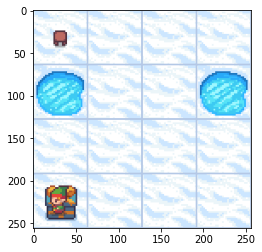

In [40]:
images = simulation(env,frozen_Q)
make_video(images,"mymovie.mp4")
play_video("mymovie.mp4")